In [154]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [155]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}')

Using cuda


In [156]:
# cria pasta de logs com data de hoje
import os
from datetime import datetime

data_hoje = datetime.now().strftime('%d-%m')
os.makedirs(f'../logs/{data_hoje}', exist_ok=True)

In [157]:
import logging

inicio_execucao = pd.Timestamp.now()

logging.basicConfig(filename=f'../logs/{data_hoje}/lstm.log', level=logging.INFO, format='- %(message)s')
logging.info('-' * 50)
logging.info(f'{inicio_execucao} - Iniciando o processo de treinamento do modelo LSTM')

In [158]:
df_original = pd.read_csv('../dados_tratados/combinado/Piratininga/Piratininga_tratado_combinado.csv',
                          usecols=['PM2.5', 'Data e Hora', 'PM10', 'Monóxido de Carbono'], low_memory=False)

In [159]:
df_original['Data e Hora'] = pd.to_datetime(df_original['Data e Hora'], format='%Y-%m-%d %H:%M:%S')
df_original.index = df_original['Data e Hora']
df_original.sort_index(inplace=True)

colunas_selecionadas = ['PM2.5', 'PM10', 'Monóxido de Carbono']
df = df_original[colunas_selecionadas]

df = df.loc['2019-01-01':'2022-01-01']

logging.info(f'Colunas Selecionadas: {colunas_selecionadas}')
df.head(20)

,PM2.5,PM10,Monóxido de Carbono
Data e Hora,,,
2019-01-01 00:30:00,37.0,45.12,0.77
2019-01-01 01:30:00,23.0,70.53,0.92
2019-01-01 02:30:00,18.0,68.99,0.81
2019-01-01 03:30:00,13.0,59.54,0.57
2019-01-01 04:30:00,7.0,30.84,0.44
2019-01-01 05:30:00,2.0,17.32,0.43
2019-01-01 06:30:00,NaN,8.84,0.4
2019-01-01 07:30:00,NaN,16.81,0.41
2019-01-01 08:30:00,NaN,9.08,0.41


In [160]:
# converte as colunas para float
df = df.apply(pd.to_numeric, errors='coerce')
df = df.replace(0.0, np.nan)
df.head(20)

,PM2.5,PM10,Monóxido de Carbono
Data e Hora,,,
2019-01-01 00:30:00,37.0,45.12,0.77
2019-01-01 01:30:00,23.0,70.53,0.92
2019-01-01 02:30:00,18.0,68.99,0.81
2019-01-01 03:30:00,13.0,59.54,0.57
2019-01-01 04:30:00,7.0,30.84,0.44
2019-01-01 05:30:00,2.0,17.32,0.43
2019-01-01 06:30:00,NaN,8.84,0.40
2019-01-01 07:30:00,NaN,16.81,0.41
2019-01-01 08:30:00,NaN,9.08,0.41


In [161]:
# Imputacao dos dados faltantes com a media da coluna

# df.fillna(df.mean(), inplace=True)

# df.interpolate(method='linear', inplace=True)

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)

df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)
df.head(20)


,PM2.5,PM10,Monóxido de Carbono
Data e Hora,,,
2019-01-01 00:30:00,37.0,45.120,0.77
2019-01-01 01:30:00,23.0,70.530,0.92
2019-01-01 02:30:00,18.0,68.990,0.81
2019-01-01 03:30:00,13.0,59.540,0.57
2019-01-01 04:30:00,7.0,30.840,0.44
2019-01-01 05:30:00,2.0,17.320,0.43
2019-01-01 06:30:00,5.6,8.840,0.40
2019-01-01 07:30:00,5.8,16.810,0.41
2019-01-01 08:30:00,4.6,9.080,0.41


In [162]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

df.head(20)

,PM2.5,PM10,Monóxido de Carbono
Data e Hora,,,
2019-01-01 00:30:00,-0.496503,-0.887537,-0.851417
2019-01-01 01:30:00,-0.692308,-0.823991,-0.822092
2019-01-01 02:30:00,-0.762238,-0.827842,-0.843597
2019-01-01 03:30:00,-0.832168,-0.851475,-0.890518
2019-01-01 04:30:00,-0.916084,-0.923249,-0.915934
2019-01-01 05:30:00,-0.986014,-0.957061,-0.917889
2019-01-01 06:30:00,-0.935664,-0.978268,-0.923754
2019-01-01 07:30:00,-0.932867,-0.958336,-0.921799
2019-01-01 08:30:00,-0.949650,-0.977667,-0.921799


In [163]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs, dtype=np.float32), np.array(ys, dtype=np.float32)


seq_length = 8
X, y = create_sequences(df.values, seq_length)

df.head(20)

,PM2.5,PM10,Monóxido de Carbono
Data e Hora,,,
2019-01-01 00:30:00,-0.496503,-0.887537,-0.851417
2019-01-01 01:30:00,-0.692308,-0.823991,-0.822092
2019-01-01 02:30:00,-0.762238,-0.827842,-0.843597
2019-01-01 03:30:00,-0.832168,-0.851475,-0.890518
2019-01-01 04:30:00,-0.916084,-0.923249,-0.915934
2019-01-01 05:30:00,-0.986014,-0.957061,-0.917889
2019-01-01 06:30:00,-0.935664,-0.978268,-0.923754
2019-01-01 07:30:00,-0.932867,-0.958336,-0.921799
2019-01-01 08:30:00,-0.949650,-0.977667,-0.921799


In [164]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

logging.info(f'X_train shape: {X_train.shape}'
             f', X_val shape: {X_val.shape}'
             f', X_test shape: {X_test.shape}')

X_train.shape, X_val.shape, X_test.shape

((18423, 8, 3), (3948, 8, 3), (3948, 8, 3))

In [165]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().reshape(-1, 1)
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float().reshape(-1, 1)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().reshape(-1, 1)

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [166]:
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

input_size = X_train.shape[2]  # Supondo que X_train seja um tensor com a forma (n_samples, seq_len, n_features)


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, drop_prob_input, drop_prob_recurrent,
                 activation_function):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.dropout_input = nn.Dropout(drop_prob_input)
        self.dropout_recurrent = nn.Dropout(drop_prob_recurrent)
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.activation_function = activation_function

    def forward(self, input_seq):
        input_seq = self.dropout_input(input_seq)
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])
        if self.activation_function == 'relu':
            predictions = nn.ReLU()(predictions)
        elif self.activation_function == 'sigmoid':
            predictions = nn.Sigmoid()(predictions)
        elif self.activation_function == 'tanh':
            predictions = nn.Tanh()(predictions)
        return predictions


def train_and_evaluate_lstm(input_size, hidden_layer_size, num_layers, lr, batch_size, drop_prob_input,
                            drop_prob_recurrent, activation_function,
                            weight_decay, num_epochs, patience):
    model = LSTM(
        input_size=input_size,
        hidden_layer_size=hidden_layer_size,
        num_layers=num_layers,
        drop_prob_input=drop_prob_input,
        drop_prob_recurrent=drop_prob_recurrent,
        output_size=1,
        activation_function=activation_function
    ).to(device)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

    # Early stopping 
    best_val_loss = np.inf
    epochs_no_improve = 0
    val_losses = []

    def train_model():
        model.train()
        for seq, labels in train_loader:
            seq, labels = seq.to(device), labels.to(device)
            optimizer.zero_grad()
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()

    def evaluate_model():
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for seq, labels in val_loader:
                seq, labels = seq.to(device), labels.to(device)
                y_pred = model(seq)
                single_loss = loss_function(y_pred, labels)
                val_loss += single_loss.item() * seq.size(0)
        val_loss /= len(val_loader.dataset)
        return val_loss

    for epoch in range(num_epochs):
        train_model()
        val_loss = evaluate_model()
        val_losses.append(val_loss)
        # print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "./best_model_lstm.pth")
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping after {} epochs".format(epoch + 1))
                break

    return model, val_losses


from sklearn.base import BaseEstimator, RegressorMixin


class PyTorchLSTMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_layer_size=2, num_layers=2, lr=0.001, batch_size=64, drop_prob_input=1.0,
                 drop_prob_recurrent=1.0,
                 activation_function='relu', weight_decay=1e-8, num_epochs=5, patience=20):
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lr = lr
        self.drop_prob_input = drop_prob_input
        self.drop_prob_recurrent = drop_prob_recurrent
        self.batch_size = batch_size
        self.activation_function = activation_function
        self.weight_decay = weight_decay
        self.num_epochs = num_epochs
        self.patience = patience

    def fit(self, X, y):
        self.model, self.val_losses = train_and_evaluate_lstm(
            input_size=input_size,
            hidden_layer_size=self.hidden_layer_size,
            num_layers=self.num_layers,
            lr=self.lr,
            batch_size=self.batch_size,
            drop_prob_input=self.drop_prob_input,
            drop_prob_recurrent=self.drop_prob_recurrent,
            activation_function=self.activation_function,
            weight_decay=self.weight_decay,
            num_epochs=self.num_epochs,
            patience=self.patience
        )
        return self

    def predict(self, X):
        self.model.eval()
        test_data = torch.from_numpy(X).float()
        test_loader = DataLoader(test_data, batch_size=self.batch_size, shuffle=False)

        predictions = []
        with torch.no_grad():
            for seq in test_loader:
                seq = seq.to(device)
                y_pred = self.model(seq)
                predictions.append(y_pred.cpu().numpy())

        predictions = np.concatenate(predictions, axis=0)
        return predictions

In [167]:
# Parâmetros para busca
param_space = {
    'hidden_layer_size': Integer(8, 256),
    'lr': Real(0.0001, 0.1, prior='log-uniform'),
    'num_layers': Integer(1, 10),
    'batch_size': Categorical([64, 96, 128]),
    'num_epochs': Categorical([400]),
    'activation_function': Categorical(['relu', 'sigmoid', 'tanh']),
    'drop_prob_input': Real(0.0, 0.5),
    'drop_prob_recurrent': Real(0.0, 0.5),
    'weight_decay': Real(1e-8, 1e-3, prior='log-uniform'),
}

logging.info(f'Espaco de Busca: \n{param_space}')

In [168]:
tscv = TimeSeriesSplit(n_splits=3)

# Usando BayesSearchCV
bayes_search = BayesSearchCV(estimator=PyTorchLSTMRegressor(), search_spaces=param_space,
                             scoring='neg_root_mean_squared_error', cv=tscv, n_iter=10, random_state=42, verbose=3)
bayes_search.fit(X_train.numpy(), y_train.numpy())

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Early stopping after 85 epochs
[CV 1/3] END activation_function=sigmoid, batch_size=128, drop_prob_input=0.46643399942391695, drop_prob_recurrent=0.15789979674352436, hidden_layer_size=346, lr=0.0017472534129202037, num_epochs=400, num_layers=8, weight_decay=3.3290211565094177e-07;, score=-0.881 total time= 2.6min
Early stopping after 113 epochs
[CV 2/3] END activation_function=sigmoid, batch_size=128, drop_prob_input=0.46643399942391695, drop_prob_recurrent=0.15789979674352436, hidden_layer_size=346, lr=0.0017472534129202037, num_epochs=400, num_layers=8, weight_decay=3.3290211565094177e-07;, score=-0.881 total time= 3.5min
Early stopping after 85 epochs
[CV 3/3] END activation_function=sigmoid, batch_size=128, drop_prob_input=0.46643399942391695, drop_prob_recurrent=0.15789979674352436, hidden_layer_size=346, lr=0.0017472534129202037, num_epochs=400, num_layers=8, weight_decay=3.3290211565094177e-07;, score=-0.879 total time=

C:\dev\scripts\pm25-plots\venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['tanh', 128, 0.0, 0.5, 512, 0.0001, 400, 1, 1e-08] before, using random point ['tanh', 128, 0.13811288867200797, 0.4487626034654042, 452, 0.029752938874847135, 400, 2, 1.714672709214299e-05]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Early stopping after 30 epochs
[CV 1/3] END activation_function=tanh, batch_size=128, drop_prob_input=0.13811288867200797, drop_prob_recurrent=0.4487626034654042, hidden_layer_size=452, lr=0.029752938874847135, num_epochs=400, num_layers=2, weight_decay=1.714672709214299e-05;, score=-0.170 total time=  23.0s
Early stopping after 22 epochs
[CV 2/3] END activation_function=tanh, batch_size=128, drop_prob_input=0.13811288867200797, drop_prob_recurrent=0.4487626034654042, hidden_layer_size=452, lr=0.029752938874847135, num_epochs=400, num_layers=2, weight_decay=1.714672709214299e-05;, score=-0.166 total time=  16.9s
Early stopping after 26 epochs
[CV 3/3] END activation_function=tanh, batch_size=128, drop_prob_input=0.13811288867200797, drop_prob_recurrent=0.4487626034654042, hidden_layer_size=452, lr=0.029752938874847135, num_epochs=400, num_layers=2, weight_decay=1.714672709214299e-05;, score=-0.175 total time=  19.8s
Fitting 3 f

BayesSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
              estimator=PyTorchLSTMRegressor(), n_iter=20, random_state=42,
              scoring='neg_root_mean_squared_error',
              search_spaces={'activation_function': Categorical(categories=('relu', 'sigmoid', 'tanh'), prior=None),
                             'batch_size': Categorical(categories=(64, 96, 128), prior=None),
                             'drop_pro...
                             'hidden_layer_size': Integer(low=8, high=512, prior='uniform', transform='normalize'),
                             'lr': Real(low=0.0001, high=0.1, prior='log-uniform', transform='normalize'),
                             'num_epochs': Categorical(categories=(400,), prior=None),
                             'num_layers': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'weight_decay': Real(low=1e-08, high=0.001, prior='log-uniform', transform='normalize')},
              verbose=3)

In [169]:
best_params = bayes_search.best_params_
best_score = -bayes_search.best_score_

X_val_np = X_val.numpy()
y_val_np = y_val.numpy()

y_pred = bayes_search.best_estimator_.predict(X_val_np)

epsilon = 1e-10
MAPE = np.mean(np.abs((y_val_np - y_pred) / (y_val_np + epsilon))) * 100
RMSE = np.sqrt(np.mean((y_val_np - y_pred) ** 2))
MAE = np.mean(np.abs(y_val_np - y_pred))
R2 = np.corrcoef(y_val_np.flatten(), y_pred.flatten())[0, 1] ** 2

print(f'Melhores Parâmetros: \n{best_params}'
      f'\nMelhor Score: {best_score}'
      # f'\nMAPE: {MAPE}'
      f'\nRMSE: {RMSE}'
      f'\nMAE: {MAE}'
      f'\nR2: {R2}'
      )

logging.info(f'Melhores Parâmetros: {best_params}')
logging.info(f'Melhor Score: {best_score}')
# logging.info(f'MAPE: {MAPE}')
logging.info(f'RMSE: {RMSE}')
logging.info(f'MAE: {MAE}')
logging.info(f'R2: {R2}')

Melhores Parâmetros: 
OrderedDict([('activation_function', 'tanh'), ('batch_size', 128), ('drop_prob_input', 0.0), ('drop_prob_recurrent', 0.0), ('hidden_layer_size', 512), ('lr', 0.0001), ('num_epochs', 400), ('num_layers', 9), ('weight_decay', 1e-08)])
Melhor Score: 0.08041773488124211
RMSE: 0.07841596752405167
MAE: 0.04932766035199165
R2: 0.48496409908053423


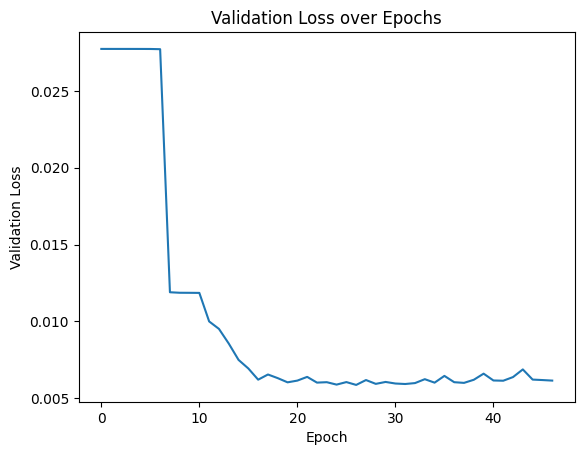

In [170]:
plt.plot(bayes_search.best_estimator_.val_losses)
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Epochs')
plt.show()

In [171]:
# Treinar o modelo com os melhores parâmetros encontrados
best_params = bayes_search.best_params_
print("Training with best parameters...")
print(best_params)

Training with best parameters...
OrderedDict([('activation_function', 'tanh'), ('batch_size', 128), ('drop_prob_input', 0.0), ('drop_prob_recurrent', 0.0), ('hidden_layer_size', 512), ('lr', 0.0001), ('num_epochs', 400), ('num_layers', 9), ('weight_decay', 1e-08)])


In [172]:
model, val_losses = train_and_evaluate_lstm(input_size=input_size, **best_params, patience=5)

# Fazer predições
model.eval()
with torch.no_grad():
    y_pred = model(X_val.to(device)).cpu().numpy()

Early stopping after 25 epochs


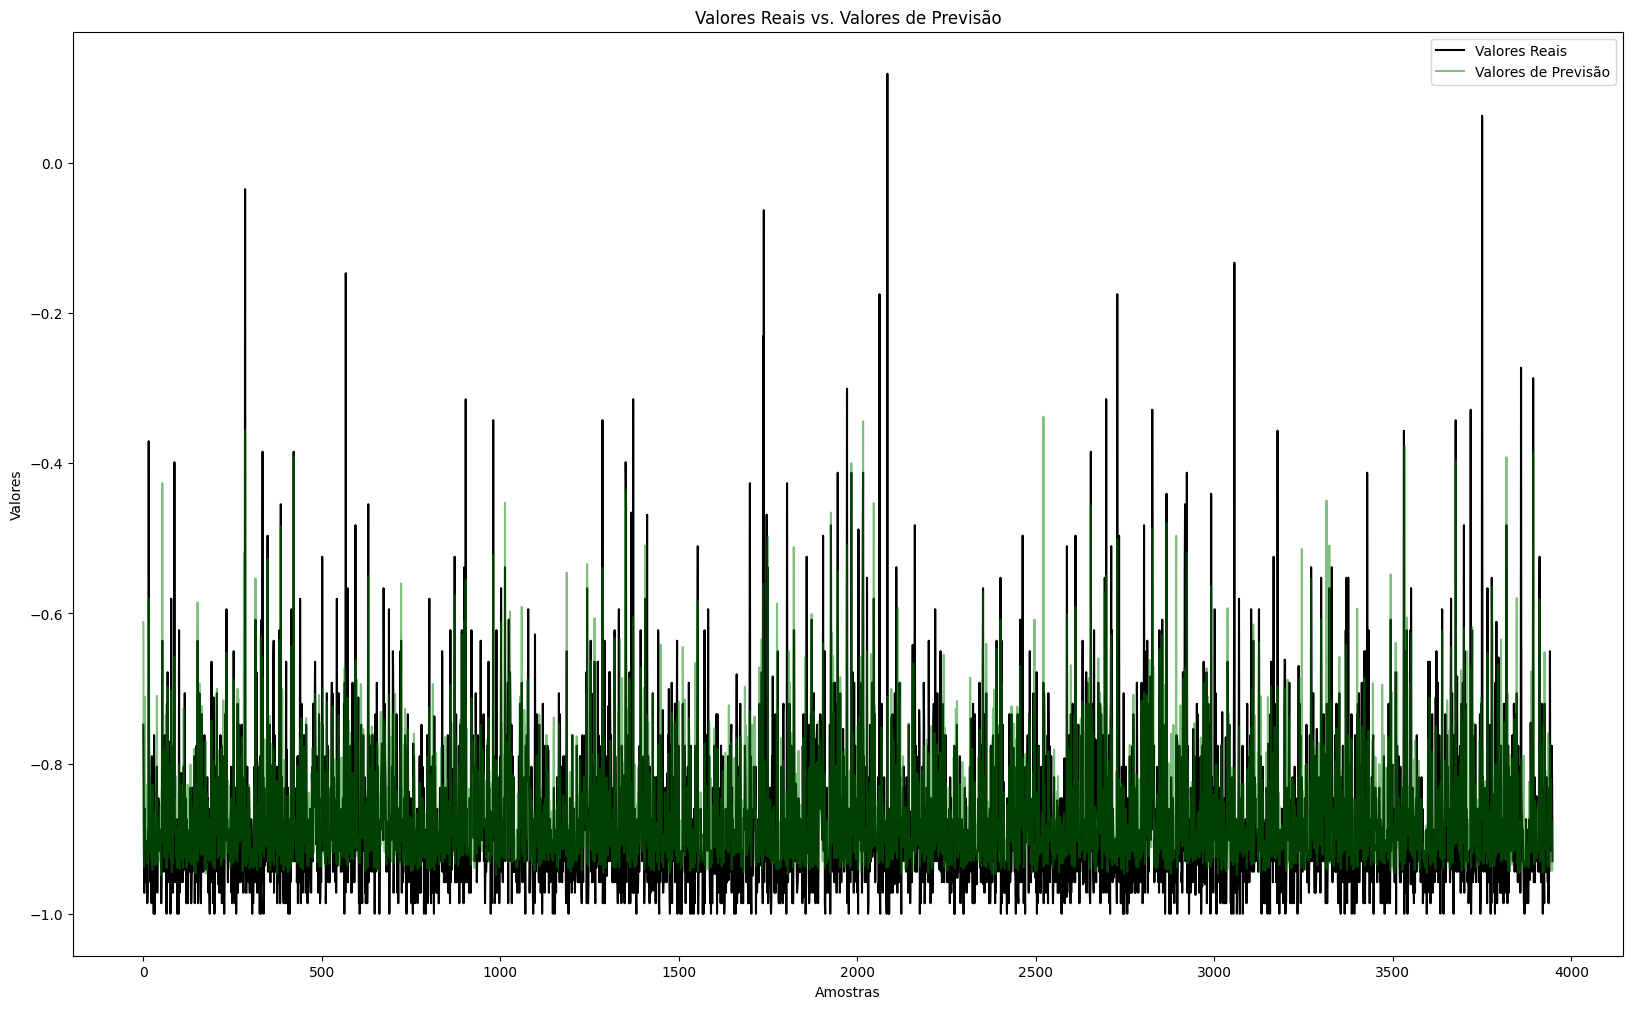

OSError: [Errno 22] Invalid argument: '../logs/.imagens/25-07/lstm_valores_reais_vs_previsao2024-07-25 19:38:59.317662.png'

<Figure size 640x480 with 0 Axes>

In [173]:
plt.figure(figsize=(20, 12))
plt.plot(y_val.numpy(), label='Valores Reais', color='black', alpha=1)
plt.plot(y_pred, label='Valores de Previsão', color='green', alpha=0.5)
plt.xlabel('Amostras')
plt.ylabel('Valores')
plt.title('Valores Reais vs. Valores de Previsão')
plt.legend()
plt.show()

# Salvar a imagem
os.makedirs(f'../logs/.imagens/{data_hoje}', exist_ok=True)
image_path = f'../logs/.imagens/{data_hoje}/lstm_valores_reais_vs_previsao' + str(inicio_execucao) + '.png'
plt.savefig(image_path)

In [ ]:
logging.info(f'Imagem Salva: {image_path}')

In [ ]:
logging.info(f'{pd.Timestamp.now()} - Fim do processo de treinamento do modelo LSTM')